In [1]:
#HW2 A4 CSE 546
#Lu Yu 2020.5
#Lasso

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

n = 500
d = 1000
k = 100

In [4]:
def createdata():
    """
    Creating some synthetic data
    w   d-by-1
    x   n-by-d
    G   n-by-1
    y   n-by-1
    """
    w=np.zeros(d)
    w[np.arange(k)]=(np.arange(k)+1)/k
    mu, sigma = 0, 1 # mean and standard deviation 
    G = np.random.normal(mu, sigma, size = n)
    x = np.random.normal(0, 1, (n, d))
    y = x.dot(w) + G
    return w, x, y

def coorddescent(lambduh, w, x, y, beta = 0.0005):
    a = np.sum(2*(x**2),axis=0)
    diff = beta + 1
    table = []
    while diff > beta:
        table.append((lambduh,int(sum(w!=0)),int(sum(w[:k,]!=0))))
        w_old = np.array(w)
        b = (y - x.dot(w)).mean()
        for j in range(d):
            c = 2*x[:,j].dot(y-(b+x.dot(w)-x[:,j]*w[j]))
            if c < -lambduh:
                w[j] = (c+lambduh)/a[j]
            elif c > lambduh:
                w[j] = (c-lambduh)/a[j]
            else:
                w[j] = 0
        diff = max(abs(w - w_old))
        lambduh = lambduh/1.5
    return table

In [5]:
w, x, y = createdata()
lambda_max = np.max(2*abs(x.T.dot(y-y.mean())))
result = np.array(coorddescent(lambda_max, w, x, y ,beta = 0.0001))

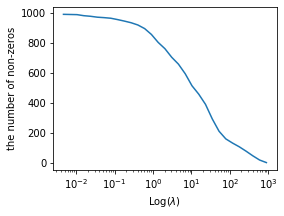

In [6]:
#Plot results
plt.figure(figsize = (4,3))
plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('the number of non-zeros')
plt.plot(result[1:,0],result[1:,1])

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


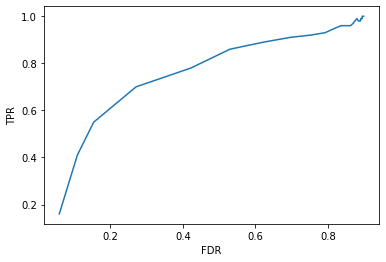

In [5]:
FDR = (result[1:,1] - result[1:,2])/result[1:,1]
TPR = result[1:,2]/k
plt.xlabel('FDR')
plt.ylabel('TPR')
plt.plot(FDR,TPR)

In [62]:
#HW2 A5 CSE 546

'''
load real data
'''
df_train = pd.read_table("crime-train.txt") 
df_test = pd.read_table("crime-test.txt")

y_train = df_train.values[:,0]#.reshape(len(df_train),1)
X_train = df_train.values[:,1:].reshape(len(df_train),df_train.shape[1]-1)
y_test = df_test.values[:,0]#.reshape(len(df_test),1)
X_test = df_test.values[:,1:].reshape(len(df_test),df_test.shape[1]-1)

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  import sys


In [64]:
def soft_threshold(rho,lamda):
    '''Soft threshold function used for normalized data and lasso regression'''
    if rho < - lamda:
        return (rho + lamda)
    elif rho >  lamda:
        return (rho - lamda)
    else: 
        return 0

def coordinate_descent_lasso(theta,X,y,lamda = .01):
    #Initialisation of useful values 
    m,n = X.shape
    beta = 0.0005
    diff = beta + 1
    #Looping until max number of iterations
    a = np.sum(2*(X**2),axis=0)
    while diff > beta: 
        theta_old = np.array(theta)
        #Looping through each coordinate
        b = (y - X.dot(theta)).mean()
        for j in range(n):
            rho = 2*X[:,j].dot(y-(b+X.dot(theta)-X[:,j]*theta[j]))
            theta[j] =  soft_threshold(rho, lamda)/a[j]
        diff = max(abs(theta - theta_old))
    return theta.flatten()

def lamda(X,y):
    lambda_ = np.max(2*abs(X.T.dot(y-y.mean())))
    lamda_list = []
    lamda_list.append(lambda_)
    while lambda_>0.01:
        lambda_ = lambda_/2
        lamda_list.append(lambda_)
    lamda = np.array(lamda_list) #Range of lambda values
    return lamda

def main_(X,y,X_test,y_test,lamda):
    # Initialize variables
    m,n = X.shape
    theta = np.zeros(n)
    theta_list = list()
    result = []
    #Run lasso regression for each lambda
    for l in lamda:
        theta = coordinate_descent_lasso(theta,X,y,lamda = l)
        error_train = np.mean((y - X.dot(theta))**2)
        error_test = np.mean((y_test - X_test.dot(theta))**2)
        theta_list.append(theta)
        result.append((l,int(sum(theta!=0)),error_train,error_test)) #record non-zeros theta

    #Stack into numpy array
    theta_lasso = np.stack(theta_list).T
    return theta_lasso,result

In [65]:
lamda = lamda(X_train,y_train)
theta_lasso, result = main_(X_train,y_train,X_test,y_test,lamda)

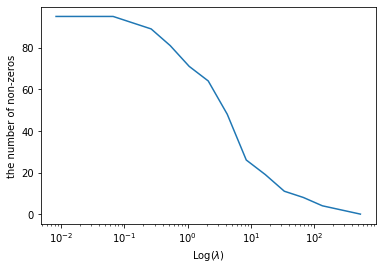

In [66]:
'''
Plot the number of nonzeros of each solution versus λ.
'''
#Plot results
#plt.figure(figsize = (4,3))
plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('the number of non-zeros')
plt.plot(np.array(result)[:,0],np.array(result)[:,1])

In [67]:
column=list(df_train.columns)
index = (column.index('agePct12t29')-1,column.index('pctWSocSec')-1, column.index('pctUrban')-1, column.index('agePct65up')-1, column.index('householdsize')-1)

(0.0047454847328514335,
 942.7759694748172,
 -0.04618787784884825,
 0.023962635093624868)

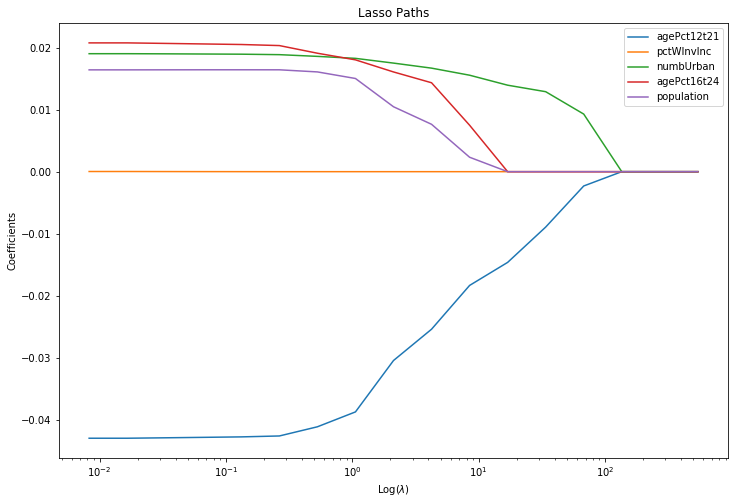

In [69]:
'''
Plot the regularization paths (in one plot) for the coefficients for input variables
'''
#Plot results
plt.figure(figsize = (12,8))

for i in index:
    plt.plot(lamda, theta_lasso[i],label = df_train.columns[i])

df_train.columns[1]
plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths')
plt.legend()
plt.axis('tight')

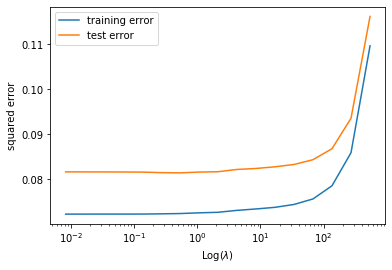

In [44]:
'''
Plot the squared error on the training and test data versus λ.
'''
plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('squared error')
plt.plot(np.array(result)[:,0],np.array(result)[:,2],label = "training error")
plt.plot(np.array(result)[:,0],np.array(result)[:,3],label = "test error")
plt.legend()

In [71]:
'''
A.5 part d  
lamda = 30
'''
lamda = np.array([30])
theta_lasso, result = main_(X_train,y_train,X_test,y_test,lamda)
print('the largest (most positive) Lasso coefficient: ', df_train.columns[np.argmax(theta_lasso)+1]) 
print('the smallest (most negative) Lasso coefficient: ', df_train.columns[np.argmin(theta_lasso)+1]) 

the largest (most positive) Lasso coefficient:  PctIlleg
the smallest (most negative) Lasso coefficient:  PctKids2Par


In [ ]:
'''A.5 part d (Cont'd)
PctIlleg: percentage of kids born to never married
    If more young people are gathered at this location, the crime rate may be higher. 
    More young people usually means higher rates of crime.

PctKids2Par: percentage of kids in family housing with two parents 
    If children and parents live together in this place, they may be in a residential
    area. This location is not like the city center, the crime rate is relatively low.
'''

In [ ]:
'''
HW 2 A.5 part e
This understanding reverses cause and effect. It is precisely because there
are more elderly people over the age of 65 living here, so the crime rate 
is low. It's as if the fire truck appeared because the building was on fire.
But if it is reversed, it may not happen.
'''

In [51]:
"""
CSE 546 HW 2 A.6
@author: Leah
"""
import numpy as np
from mnist import MNIST
from matplotlib import pyplot as plt


def load_dataset():
    mndata = MNIST('./data/')
    #mndata = MNIST('./dir_with_mnist_data_files')
    X_train, labels_train = map(np.array, mndata.load_training()) 
    X_test, labels_test = map(np.array, mndata.load_testing()) 
    X_train = X_train/255.0
    X_test = X_test/255.0
   
    return X_train, labels_train, X_test, labels_test

def weightInitialization(n_features):
    w = np.zeros(n_features)
    b = 0
    return w,b

def sigmoid(x): 
    return (1/(1 + np.exp(-x))) #mu_w

def probability(X, y, w, b):   #\mu
    return sigmoid((np.dot(X,w)+b)*y)

def Model_optimization(w,b,X,y,lamda):
    mu =  probability(X,y,w,b)
    dw = (- np.multiply(X.T, y) * (1 - mu)).mean(axis=1) + 2 * lamda * w
    db = np.mean(( mu -1).T*y)
    return mu, dw, db

def Model_prediction(w, b, X, Y, X_test,Y_test, lamda, learning_rate, no_iterations):
    cost_history_train = []
    iterations = []
    cost_history_test = []
    misclassified_train_history = []
    misclassified_test_history = []
    for i in range(no_iterations):
        mu, dw, db = Model_optimization(w,b,X,Y,lamda)
        J_train = np.log(1/mu).mean() + lamda * np.linalg.norm(w, ord = 2) 
        #weight update
        #Gradient Descent with Ridge Regularization calculation 
        w = w - (learning_rate * (dw.T))
        b = b - (learning_rate * db)
        
        if (i % 20 == 0):
            iterations.append(i)
            cost_history_train.append(J_train)
            #mu,_,_ = Model_optimization(w,b,X_test,Y_test,lamda)
            J_test = np.log(1/probability(X_test,Y_test,w,b)).mean() + lamda * np.linalg.norm(w, ord = 2) 
            cost_history_test.append(J_test)
            
            X_train_pred = np.dot(X,w)+b
            X_train_pred[X_train_pred <= 0] = -1
            X_train_pred[X_train_pred > 0] = 1
            #misclassified
            misclassified_train  = 1 - (X_train_pred == Y).sum() / float(X.shape[0])
            misclassified_train_history.append(misclassified_train)
            
            X_test_pred = np.dot(X_test,w)+b
            X_test_pred[X_test_pred <= 0] = -1
            X_test_pred[X_test_pred > 0] = 1
            misclassified_test  = 1 - (X_test_pred == Y_test).sum() / float(X_test.shape[0])
            misclassified_test_history.append(misclassified_test)
            
    #final parameters
    coeff = {"w": w, "b": b}
    cost_history = {'train':cost_history_train, 'test':cost_history_test}
    gradient = {"dw": dw, "db": db}
    misclassified = {'train':misclassified_train_history, 'test':misclassified_test_history}
    
    return coeff, gradient, cost_history,misclassified, iterations

def Model_Prediction_sgd(w, b, X, Y, X_test,Y_test, lamda, learning_rate, no_iterations,batch_size = 10):
    cost_history_train = []
    cost_history_test = []
    misclassified_train_history = []
    misclassified_test_history = []
    iterations = []
    m = X.shape[0]

    for i in range(no_iterations):
        # Stochastic Gradient Descent with Ridge Regularization calculation 
        idx = np.random.randint(0, m, size=batch_size)
        X_batch = X[idx]
        Y_batch = Y[idx]
        mu, dw, db= Model_optimization(w,b,X_batch,Y_batch,lamda)
        loss_train = np.log(1/probability(X, Y,w,b)).mean() + lamda * np.linalg.norm(w, ord = 2) 

        #weight update
        w = w - (learning_rate * (dw.T))
        b = b - (learning_rate * db)
        
        if (i % 20 == 0):
            iterations.append(i)
            cost_history_train.append(loss_train)
            loss_test = np.log(1/probability(X_test,Y_test,w,b)).mean() + lamda * np.linalg.norm(w, ord = 2) 
            cost_history_test.append(loss_test)
            
            X_train_pred = np.dot(X,w)+b
            X_train_pred[X_train_pred <= 0] = -1
            X_train_pred[X_train_pred > 0] = 1
            #misclassified
            misclassified_train  = 1 - (X_train_pred == Y).sum() / float(X.shape[0])
            misclassified_train_history.append(misclassified_train)
            
            X_test_pred = np.dot(X_test,w)+b
            X_test_pred[X_test_pred <= 0] = -1
            X_test_pred[X_test_pred > 0] = 1
            misclassified_test  = 1 - (X_test_pred == Y_test).sum() / float(X_test.shape[0])
            misclassified_test_history.append(misclassified_test)
    #final parameters
    coeff_sgd = {"w": w, "b": b}
    gradient_sgd = {"dw": dw, "db": db}
    cost_history = {'train':cost_history_train, 'test':cost_history_test}
    misclassified = {'train':misclassified_train_history, 'test':misclassified_test_history}
    
    return coeff_sgd, gradient_sgd, cost_history, misclassified, iterations

In [5]:
#-----------------------------------------------------------------
#  Main
#-----------------------------------------------------------------

#LOAD data
X_train, labels_train, X_test, labels_test = load_dataset()

labels_train = np.array(labels_train, dtype = 'int32')
labels_test = np.array(labels_test, dtype = 'int32')

#extract digit 2 and 7
X_train_binary = np.hstack((X_train[np.where(labels_train[:]==2),:],X_train[np.where(labels_train[:]==7),:]))
X_train_binary = X_train_binary[0]
labels_train_binary = np.hstack((labels_train[np.where(labels_train[:]==2)],labels_train[np.where(labels_train[:]==7)]))
labels_train_binary[labels_train_binary[:]==2] = -1
labels_train_binary[labels_train_binary[:]==7] = 1

X_test_binary = np.hstack((X_test[np.where(labels_test[:]==2),:],X_test[np.where(labels_test[:]==7),:]))
X_test_binary = X_test_binary[0]
labels_test_binary = np.hstack((labels_test[np.where(labels_test[:]==2)],labels_test[np.where(labels_test[:]==7)]))
labels_test_binary[labels_test_binary[:]==2] = -1
labels_test_binary[labels_test_binary[:]==7] = 1
#-----------------------------------------------------------------

n_features = X_train_binary.shape[1]


In [56]:
#GD
n_iter = 5000
eta = 0.005
w, b = weightInitialization(n_features) #Initialization
coeff, gradient, cost_history, misclassified,iterations= Model_prediction(w, b, X_train_binary, labels_train_binary, X_test_binary, labels_test_binary, lamda = 0.1, learning_rate = eta, no_iterations=n_iter)


Text(0.5, 1.0, 'Learning Curve')

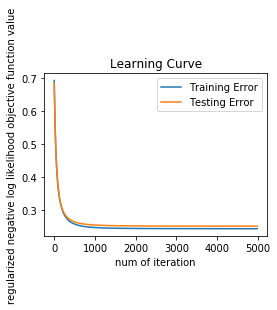

In [57]:
#Plot results
plt.figure(figsize = (4,3))
plt.xlabel('num of iteration')
plt.ylabel('regularized negative log likelihood objective function value')
plt.plot(iterations[:],cost_history['train'][:])
plt.plot(iterations[:],cost_history['test'][:])
plt.legend(['Training Error', 'Testing Error'], loc='best')
plt.title('Learning Curve')

Text(0.5, 1.0, 'Learning Curve')

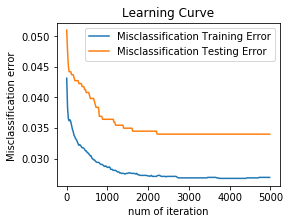

In [58]:
plt.figure(figsize = (4,3))
plt.xlabel('num of iteration')
plt.ylabel('Misclassification error ')
plt.plot(iterations[:],misclassified['train'][:])
plt.plot(iterations[:],misclassified['test'][:])
plt.legend(['Misclassification Training Error', 'Misclassification Testing Error'], loc='best')
plt.title('Learning Curve')

Text(0.5, 1.0, 'Learning Curve')

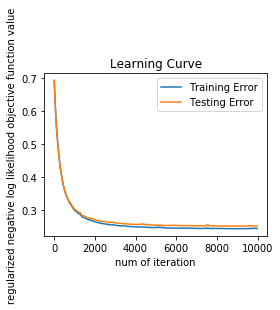

In [49]:
###SGD
batch_size = 1
n_iter = 10000
eta = 0.001
w, b = weightInitialization(n_features) #Initialization
coeff, gradient,cost_history, misclassified, iterations = Model_Prediction_sgd(w, b, X_train_binary, labels_train_binary, X_test_binary, labels_test_binary, lamda = 0.1, learning_rate = eta, no_iterations=n_iter, batch_size = batch_size)

#Plot results
plt.figure(figsize = (4,3))
plt.xlabel('num of iteration')
plt.ylabel('regularized negative log likelihood objective function value')
plt.plot(iterations[:],cost_history['train'][:])
plt.plot(iterations[:],cost_history['test'][:])
plt.legend(['Training Error', 'Testing Error'], loc='best')
plt.title('Learning Curve')

Text(0.5, 1.0, 'Learning Curve')

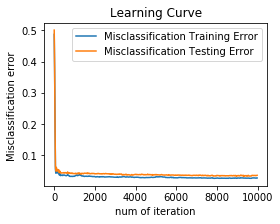

In [52]:
plt.figure(figsize = (4,3))
plt.xlabel('num of iteration')
plt.ylabel('Misclassification error ')
plt.plot(iterations[:],misclassified['train'][:])
plt.plot(iterations[:],misclassified['test'][:])
plt.legend(['Misclassification Training Error', 'Misclassification Testing Error'], loc='best')
plt.title('Learning Curve')


Text(0.5, 1.0, 'Learning Curve')

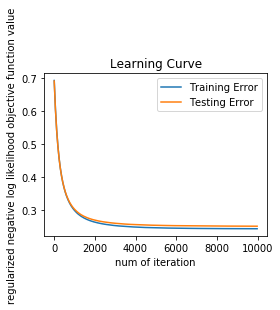

In [53]:
batch_size = 100
n_iter = 10000
eta = 0.001
w, b = weightInitialization(n_features) #Initialization
coeff, gradient, cost_history, misclassified, iterations = Model_Prediction_sgd(w, b, X_train_binary, labels_train_binary, X_test_binary, labels_test_binary, lamda = 0.1, learning_rate = eta, no_iterations=n_iter, batch_size = batch_size,)
#Plot results
plt.figure(figsize = (4,3))
plt.xlabel('num of iteration')
plt.ylabel('regularized negative log likelihood objective function value')
plt.plot(iterations[:],cost_history['train'][:])
plt.plot(iterations[:],cost_history['test'][:])
plt.legend(['Training Error', 'Testing Error'], loc='best')
plt.title('Learning Curve')

Text(0.5, 1.0, 'Learning Curve')

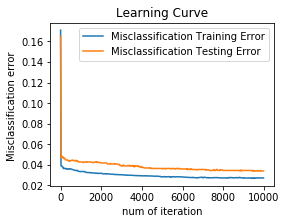

In [54]:
plt.figure(figsize = (4,3))
plt.xlabel('num of iteration')
plt.ylabel('Misclassification error ')
plt.plot(iterations[:],misclassified['train'][:])
plt.plot(iterations[:],misclassified['test'][:])
plt.legend(['Misclassification Training Error', 'Misclassification Testing Error'], loc='best')
plt.title('Learning Curve')
